# IN6232

# Import Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score


def ip_to_int(ip):
    """
    Convert an IP address string to an integer. If ip is already an integer,
    it's returned as is.
    """
    if isinstance(ip, int):
        return ip  # Already an integer, no conversion needed
    octets = ip.split('.')
    return sum(int(octet) * (256 ** i) for i, octet in enumerate(reversed(octets)))

def int_to_ip(ip_int):
    """Convert an integer to an IP address string."""
    return '.'.join(map(str, [(ip_int >> (8 * i)) & 0xFF for i in range(3, -1, -1)]))



# Load training set

In [2]:
training_data = pd.read_csv('/Users/jerry/Documents/Assignment/Dados_Deolindo/Testsetgood.csv')  # Replace with the path to your training dataset

# Preprocess the training dataset

In [3]:
# Print columns for verification
print("Columns in the dataset:", training_data.columns)

Columns in the dataset: Index(['Timestamp', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'TCP Length', 'Label'],
      dtype='object')


In [4]:
# Check each column's data type and print whether it's categorical or numerical
for column in training_data:
    # Define the data type of the column
    dtype = training_data[column].dtype
    
    # Check if the column is of object type or category type, commonly used for categorical data
    if dtype == 'object' or dtype.name == 'category':
        print(f"Column '{column}' is categorical.")
    # Check if the column is of numeric type
    elif pd.api.types.is_numeric_dtype(dtype):
        print(f"Column '{column}' is numerical.")
    else:
        print(f"Column '{column}' is of type {dtype} and is neither clearly numerical nor categorical.")


Column 'Timestamp' is categorical.
Column 'Source IP' is categorical.
Column 'Source Port' is numerical.
Column 'Destination IP' is categorical.
Column 'Destination Port' is numerical.
Column 'TCP Length' is numerical.
Column 'Label' is numerical.


In [5]:
#Changing timestamp to unix mode
training_data['Timestamp'] = pd.to_datetime(training_data['Timestamp'])
training_data['Timestamp'] = training_data['Timestamp'].astype(int) / 10**9  # Convert to Unix timestamp


In [6]:
#Changing IP to integer
training_data['Source IP'] = training_data['Source IP'].apply(ip_to_int)
training_data['Destination IP'] = training_data['Destination IP'].apply(ip_to_int)
training_data.to_csv('/Users/jerry/Documents/Assignment/testsettocheckonly.csv', index=False)

In [7]:
# Drop the 'ID' column if it exists in your dataset
if 'ID' in training_data.columns:
    training_data.drop(columns=['ID'], inplace=True)
    



# Split the training dataset into training and validation sets


In [8]:
X_train = training_data.drop('Label', axis=1)  # Features
y_train = training_data['Label']  # Target

# Splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Apply ip_to_int conversion on IP columns in both X_train and X_val
X_train['Source IP'] = X_train['Source IP'].apply(ip_to_int)
X_train['Destination IP'] = X_train['Destination IP'].apply(ip_to_int)
X_val['Source IP'] = X_val['Source IP'].apply(ip_to_int)
X_val['Destination IP'] = X_val['Destination IP'].apply(ip_to_int)

# Training the Decision Tree model

In [9]:
# Train the Decision Tree Classifier
print(X_train.dtypes)

Timestamp           float64
Source IP             int64
Source Port           int64
Destination IP        int64
Destination Port      int64
TCP Length            int64
dtype: object


In [10]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [11]:
# Define the parameter grid
dt_param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_samples_split': [2, 5, 10]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5, n_jobs=-1, verbose=1)
dt_grid_search.fit(X_train, y_train)
print("Best hyperparameters for Decision Tree:", dt_grid_search.best_params_)

best_dt_classifier = dt_grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


# Validate the Decision Tree model


In [12]:
y_val_pred_dt = dt_classifier.predict(X_val)
print("Decision Tree Validation Accuracy Score:", accuracy_score(y_val, y_val_pred_dt))

# Cross-Validation for Decision Tree
dt_cross_val_scores = cross_val_score(best_dt_classifier, X_train, y_train, cv=5)
print("Cross-validation accuracy for Decision Tree:", dt_cross_val_scores.mean())

# Use `best_dt_classifier` for other predictions or analyses as needed

Decision Tree Validation Accuracy Score: 1.0
Cross-validation accuracy for Decision Tree: 0.9999750654531854


# Training the Random Forest Classifier Model


In [13]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
    # Random Forest Hyperparameter Tuning
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 5]
    }
    
    rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, verbose=1)
    rf_grid_search.fit(X_train, y_train)
    print("Best hyperparameters for Random Forest:", rf_grid_search.best_params_)
    
    best_rf_classifier = rf_grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# Validate the Random Forest model


In [15]:
y_val_pred_rf = rf_classifier.predict(X_val)
print("Random Forest Validation Accuracy Score:", accuracy_score(y_val, y_val_pred_rf))

# Cross-Validation for Random Forest
rf_cross_val_scores = cross_val_score(best_rf_classifier, X_train, y_train, cv=5)
print("Cross-validation accuracy for Random Forest:", rf_cross_val_scores.mean())


Random Forest Validation Accuracy Score: 1.0
Cross-validation accuracy for Random Forest: 0.9999800523625483


# Load the test dataset


In [16]:
test_data = pd.read_csv('/Users/jerry/Documents/Assignment/output.csv')  # Replace with the path to your test dataset


# Preprocess the test dataset similarly to the training dataset


In [17]:
# Print columns for verification
print("Columns in the dataset:", test_data.columns)



Columns in the dataset: Index(['Timestamp', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'TCP Length'],
      dtype='object')


In [18]:
# Check each column's data type and print whether it's categorical or numerical
for column in test_data:
    # Define the data type of the column
    dtype = test_data[column].dtype
    
    # Check if the column is of object type or category type, commonly used for categorical data
    if dtype == 'object' or dtype.name == 'category':
        print(f"Column '{column}' is categorical.")
    # Check if the column is of numeric type
    elif pd.api.types.is_numeric_dtype(dtype):
        print(f"Column '{column}' is numerical.")
    else:
        print(f"Column '{column}' is of type {dtype} and is neither clearly numerical nor categorical.")

Column 'Timestamp' is categorical.
Column 'Source IP' is categorical.
Column 'Source Port' is numerical.
Column 'Destination IP' is categorical.
Column 'Destination Port' is numerical.
Column 'TCP Length' is numerical.


In [19]:
# Convert timestamp to Unix timestamp
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])
test_data['Timestamp'] = test_data['Timestamp'].astype('int64') // 10**9

# Convert IP addresses to integers if not already done
if test_data['Source IP'].dtype == 'object':
    test_data['Source IP'] = test_data['Source IP'].apply(ip_to_int)

if test_data['Destination IP'].dtype == 'object':
    test_data['Destination IP'] = test_data['Destination IP'].apply(ip_to_int)



In [20]:
# Drop the 'ID' column if it exists in your dataset
if 'ID' in test_data.columns:
    test_data.drop(columns=['ID'], inplace=True)
    
print("Data types before conversion:\n", X_train.dtypes)
print(test_data.tail())

Data types before conversion:
 Timestamp           float64
Source IP             int64
Source Port           int64
Destination IP        int64
Destination Port      int64
TCP Length            int64
dtype: object
       Timestamp  Source IP  Source Port  Destination IP  Destination Port  \
4019  1603442139  167772677            1       167772676             45251   
4020  1603442139  167772676        45252       167772677                 1   
4021  1603442139  167772677            1       167772676             45252   
4022  1603442139  167772676        45253       167772677                 1   
4023  1603442139  167772677            1       167772676             45253   

      TCP Length  
4019           6  
4020           0  
4021           6  
4022           0  
4023           6  


In [21]:
# Print columns for verification
print("Columns in the dataset:", test_data.columns)

Columns in the dataset: Index(['Timestamp', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'TCP Length'],
      dtype='object')


# Predicting

In [22]:
# Features used during training
training_features = X_train.columns

# Select only the relevant features from the test data and ensure the order matches
test_data_for_prediction = test_data[training_features]

# Assuming 'best_dt_classifier' and 'best_rf_classifier' are your best models from GridSearchCV
# Predict using the optimized Decision Tree model
test_predictions_dt = best_dt_classifier.predict(test_data_for_prediction)

# Predict using the optimized Random Forest model
test_predictions_rf = best_rf_classifier.predict(test_data_for_prediction)

# Add model predictions as new columns to the test data
test_data['DT_Predicted_Label'] = test_predictions_dt
test_data['RF_Predicted_Label'] = test_predictions_rf

# Display the test data with the newly added prediction columns
print(test_data[['DT_Predicted_Label', 'RF_Predicted_Label']].head())
print(test_data[['DT_Predicted_Label', 'RF_Predicted_Label']].tail())


   DT_Predicted_Label  RF_Predicted_Label
0                   0                   0
1                   0                   0
2                   0                   0
3                   0                   0
4                   0                   0
      DT_Predicted_Label  RF_Predicted_Label
4019                   0                   0
4020                   0                   0
4021                   0                   0
4022                   0                   0
4023                   0                   0


In [23]:
# Convert Unix Timestamp back to normal date-time format
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], unit='s')

# Convert integer IP addresses back to standard IP format
test_data['Source IP'] = test_data['Source IP'].apply(int_to_ip)
test_data['Destination IP'] = test_data['Destination IP'].apply(int_to_ip)

# Now you can export the modified test dataset
test_data.to_csv('/Users/jerry/Documents/Assignment/newtestset_with_original_formats1.csv', index=False)

In [24]:
# Count the number of instances predicted as port scanning by each model
dt_port_scan_count = test_data['DT_Predicted_Label'].sum()
rf_port_scan_count = test_data['RF_Predicted_Label'].sum()

# Calculate the total number of instances in the test dataset
total_instances = len(test_data)

# Calculate the percentage of instances predicted as port scanning
dt_port_scan_percentage = (dt_port_scan_count / total_instances) * 100
rf_port_scan_percentage = (rf_port_scan_count / total_instances) * 100

# Print the results
print(f"Decision Tree Model predicted {dt_port_scan_percentage:.2f}% of instances as port scanning.")
print(f"Random Forest Model predicted {rf_port_scan_percentage:.2f}% of instances as port scanning.")


Decision Tree Model predicted 5.12% of instances as port scanning.
Random Forest Model predicted 3.58% of instances as port scanning.


# Evaluate the models on the test dataset


In [25]:
# Plot the Decision Tree

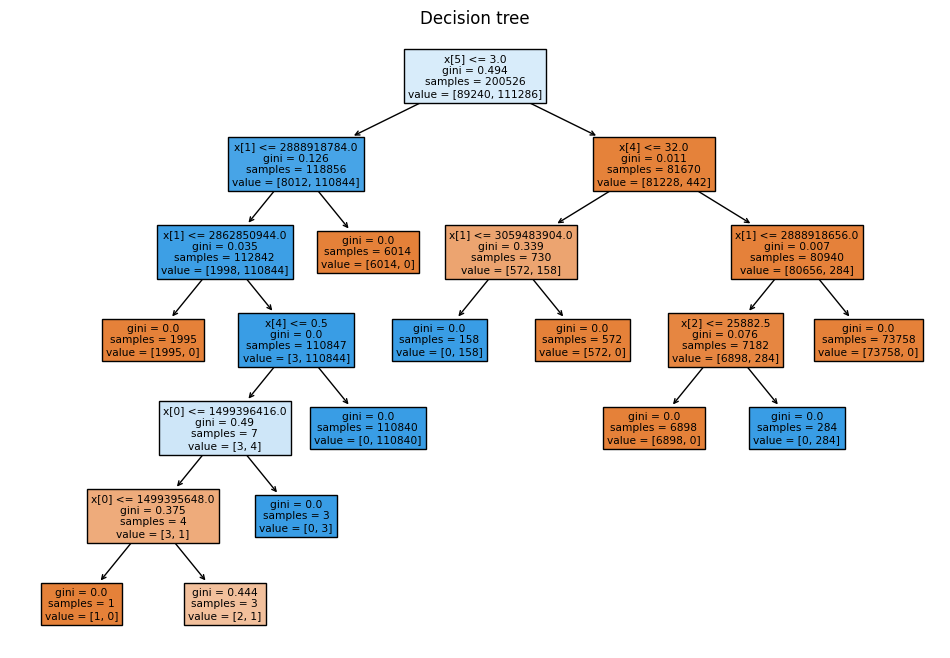

In [26]:
plt.figure(figsize=(12,8))
plot_tree(dt_classifier, filled=True)
plt.title("Decision tree")
plt.show()

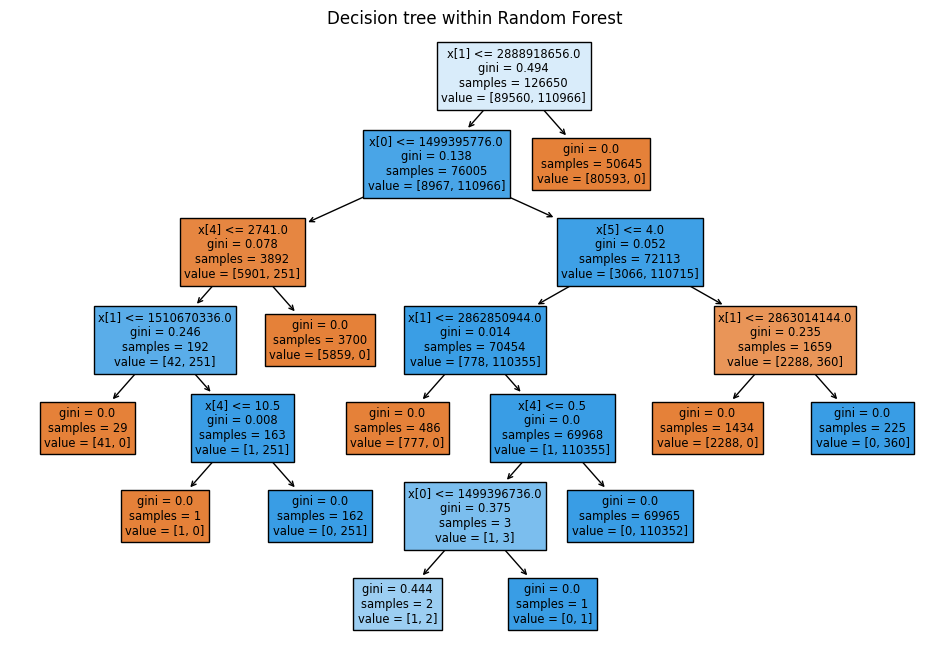

In [28]:
# Plot the first decision tree in the Random Forest
plt.figure(figsize=(12, 8))
plot_tree(rf_classifier.estimators_[0], filled=True)
plt.title("Decision tree within Random Forest")
plt.show()